# Project 3 Costa Rican Household Poverty Level Prediction

### <center>Yonggang Li (18043158)</center>

### Abstract
This notebook introduced ways to explore the observable household attributes from Costa Rican families. The missing values are filled, redudant features are dropped and multiple records for a household are merged into one. Some classifiers, k-means clustering, kNN, Decision Tree, Naive Bayes, Neural Network, and Gradient Boosting, are compared and the best model is selected based on 5-fold cross validation result.

### Introduction 
Please check <a herf='https://www.kaggle.com/c/costa-rican-household-poverty-prediction'> Costa Rican Household Poverty Level Prediction</a> for the background details. <br>
To run this notebook, sklearn needs to be upgraded to 0.19 or higher, please run the commands to upgrade,<br>
* !pip install -U scikit-learn
* !python -m pip install --upgrade pip

<b>Import necessary data analysis libraries</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['figure.figsize'] = 20, 15
rcParams['font.size'] = 24
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'k'

%matplotlib inline

pd.set_option('html', True)

<b>Some utility functions are defined first.</b>

In [2]:
# load train data and check the missing value
def hh_load_data(file_name):
    household = pd.read_csv(file_name, na_values=[''])
    # map 'yes' and 'no' to 1 and 0 respectively for edjefa
    def yes_no_mapper(v):
        if v == 'yes':
            return 1
        elif v == 'no':
            return 0
        else:
            return v
    household["edjefa"] = household[["edjefa"]].applymap(yes_no_mapper)
    
    na_checker = household.isnull().any()
    print "There are NA in variables: "
    print na_checker[na_checker == True].index
    return household

# by looking at the data dictionary, adopt different strategies to fill missin values
# use mean to fill NA of v2a1
def hh_fill_na(raw_df):
    raw_df['v2a1'].fillna(value=np.mean(raw_df.v2a1), inplace=True)
    # tipovivi1=1 own and fully paid house, set NA to zero for such cases
    raw_df.loc[(raw_df['tipovivi1'] == 1), 'v2a1'] = 0
    
    if any(np.equal(raw_df.columns.values, "Target")):
        for i in range(4):
            pay = raw_df[raw_df.Target == 1+i].v2a1.mean()
            raw_df.loc[(raw_df.tipovivi1 == 0) & (raw_df.v2a1 == 0) & (raw_df.Target == i+1) , 'v2a1'] = pay
    else:
        raw_df.loc[(raw_df.tipovivi1 == 0) & (raw_df.v2a1 == 0), 'v2a1'] = raw_df.v2a1.mean()
        
    # v18q1 is # tablets, set 0 for missing values
    raw_df['v18q1'].fillna(value=0, inplace=True)
    # rez_esc is years behind in school, set 0
    raw_df['rez_esc'].fillna(value=0, inplace=True)
    # meaneduc is average years of education for adults (18+), use mean to fill NA
    raw_df['meaneduc'].fillna(value=raw_df['meaneduc'].mean(), inplace=True)
    # SQBmeaned is the square of the mean years of education of adults (>=18) in the household, 
    # use square of meaneduc to fill NA
    raw_df['SQBmeaned'].fillna(value=pow(raw_df['meaneduc'], 2), inplace=True)
    
# individual level variables, others are household level variables
agg_vars = pd.Series(['dis','male','female','estadocivil1','estadocivil2','estadocivil3','estadocivil4','estadocivil5',
                      'estadocivil6','estadocivil7','parentesco1','parentesco2','parentesco3','parentesco4','parentesco5',
                      'parentesco6','parentesco7','parentesco8','parentesco9','parentesco10','parentesco11','parentesco12'])

# normalize all variables except binary variables (0 or 1) and target
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
def hh_normalize(raw_df):
    for col in raw_df.columns:
        if (col != 'Target' and col != 'idhogar' and len(raw_df[col].unique()) > 2):
            raw_df[col] = min_max_scaler.fit_transform(raw_df[col].reshape(-1, 1))


### Load data and data wrangling
#### Download data from https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data and load <br>

In [3]:
household = hh_load_data('train.csv')
# set index to Id
household.set_index('Id', inplace=True)
household.index.name = None
hh_fill_na(household)
household.head()

There are NA in variables: 
Index([u'v2a1', u'v18q1', u'rez_esc', u'meaneduc', u'SQBmeaned'], dtype='object')


,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
ID_279628684,190000,0,3,0,1,1,0,0,0,1,...,100,1849,1,100,0,1.000000,0,100,1849,4
ID_f29eb3ddd,135000,0,4,0,1,1,1,1,0,1,...,144,4489,1,144,0,1.000000,64,144,4489,4
ID_68de51c94,0,0,8,0,1,1,0,0,0,0,...,121,8464,1,0,0,0.250000,64,121,8464,4
ID_d671db89c,180000,0,5,0,1,1,1,1,0,2,...,81,289,16,121,4,1.777778,1,121,289,4
ID_d56d6f5f5,180000,0,5,0,1,1,1,1,0,2,...,121,1369,16,121,4,1.777778,1,121,1369,4


#### Check the records and how the poverty of the households distributed 

In [4]:
hh_grp = household.idhogar.value_counts()
print 'There are %d household, %d records with household head.'%(len(hh_grp), len(household[household.parentesco1==1]))
household.info()

There are 2988 household, 2973 records with household head.
<class 'pandas.core.frame.DataFrame'>
Index: 9557 entries, ID_279628684 to ID_a38c64491
Columns: 142 entries, v2a1 to Target
dtypes: float64(8), int64(130), object(4)
memory usage: 10.4+ MB


We can see that there are 9556 records from 2988 households and most records (2973) with household head presents.

#### Fix errors that households have different Target from family members

In [5]:
def fix_target_level(raw_df):
    all_equal = raw_df.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
    not_equal = all_equal[all_equal == False]
    print raw_df[raw_df['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]
    for hhid in not_equal.index:
        correct_level = int(raw_df[(raw_df['idhogar'] == hhid) & (raw_df['parentesco1'] == 1.0)]['Target'])
        raw_df.loc[raw_df['idhogar'] == hhid, 'Target'] = correct_level
        
fix_target_level(household)

                idhogar  parentesco1  Target
ID_a5e2b0639  0172ab1d9            0       3
ID_5dfdf4ebe  0172ab1d9            0       2
ID_762e1fd96  0172ab1d9            0       3
ID_c76b87004  0172ab1d9            1       3
ID_1dffe3dcf  0172ab1d9            0       2


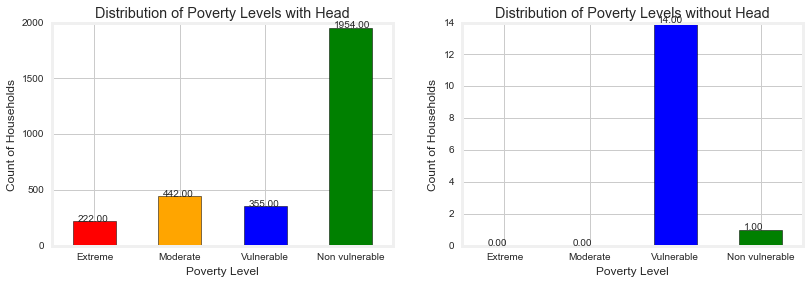

In [6]:
poverty_colors = ['red', 'orange', 'blue', 'green']
poverty_levels = ['extreme', 'moderate', 'vulnerable', 'non vulnerable']

def hh_proverty_breakdown(hh_df):
    levels = ['Extreme', 'Moderate', 'Vulnerable', 'Non vulnerable']
    # head presenting household poverty levels
    poverty_levels = [0, 0, 0, 0]
    t = household[household.parentesco1==1]
    for v in t['Target'].values:
        poverty_levels[v-1] += 1
    
    poverty1 = pd.DataFrame({'level': levels, 'count':poverty_levels})
    
    plt1 = plt.subplot(1, 2, 1)
    ax = poverty1.plot(ax=plt1, kind='bar', x='level', y='count', color=poverty_colors, rot=0, edgecolor='k', legend=False, figsize=(10,4))
    plt.xlabel('Poverty Level'); 
    plt.ylabel('Count of Households');
    plt.title('Distribution of Poverty Levels with Head') 
    for p in ax.patches:
        b = p.get_bbox()
        val = "{:.2f}".format(b.y1 + b.y0)        
        ax.annotate(val, ((b.x0 + b.x1)/2-0.2, b.y1))

    # no-head household poverty levels
    poverty_levels = [0, 0, 0, 0]
    no_head = set(hh_df.idhogar.unique()) - set(hh_df[hh_df.parentesco1 == 1 ].idhogar.unique())
    targets = []
    for v in no_head:
        targets.append(hh_df[hh_df.idhogar == v].Target[0])
    for v in targets:
        poverty_levels[v-1] += 1

    poverty2 = pd.DataFrame({'level': levels, 'count':poverty_levels})
    plt2 = plt.subplot(1, 2, 2)
    ax = poverty2.plot(ax=plt2, kind='bar', x='level', y='count', color=['r','y','b','g'], rot=0, edgecolor='k', legend=False, figsize=(12,4))
    plt.xlabel('Poverty Level'); 
    plt.ylabel('Count of Households');
    plt.title('Distribution of Poverty Levels without Head') 
    for p in ax.patches:
        b = p.get_bbox()
        val = "{:.2f}".format(b.y1 + b.y0)        
        ax.annotate(val, ((b.x0 + b.x1)/2-0.2, b.y1))
hh_proverty_breakdown(household)

The chart shows there are 66% households that classify as non vulnerable and only 7.5% are extremly poor. This imbalanced distribution brings difficulty for predicting the minority classes because the model far less examples. For no head households, almost all are vulnerable and only one case is non-vulnerable. Let's assume the test data should also conform to these patterns.

### Feature Analysis
First, let's keep squared varaibles (SQB*) but opt out the original variables

In [7]:
optout_vars = [u'hogar_total', u'edjefe', u'hogar_nin', u'overcrowding', u'dependency', u'meaneduc', u'agesq']
household.drop(optout_vars, axis=1, inplace=True)

v18q, r4h3, r4m3, r4t3, mobilephone(qmobilephone) are derived variables, hhsize is duplicate with tamhog, tamviv duplicate with r4t3, drop them too

In [8]:
#area2 and area1, female and male, are all dup, keep one
household.drop([u'v18q', u'tamhog', u'area2', 'female'], axis=1, inplace=True)

In [9]:
#make a new variable house size per person and then remove hhsize and tamviv
def create_per_person_vars(raw_df):
    raw_df['size_per_person'] = raw_df['hhsize']*1.0/raw_df['tamviv']
    raw_df['rent_per_person'] = raw_df['v2a1'] / raw_df['tamviv']
    raw_df['phones_per_person'] = raw_df['qmobilephone'] / raw_df['tamviv']
    raw_df['tablets_per_person'] = raw_df['v18q1'] / raw_df['tamviv']
    raw_df['rooms_per_person'] = raw_df['rooms'] / raw_df['tamviv']
    raw_df.drop([u'hhsize', u'rooms', u'v18q1', u'v2a1' , u'qmobilephone', u'tamviv'], axis=1, inplace=True)

create_per_person_vars(household)

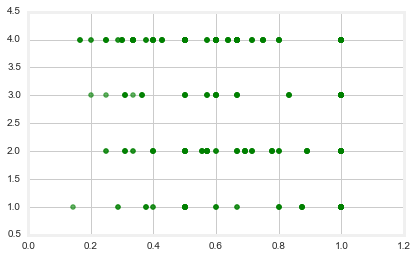

In [10]:
plt.scatter(household['size_per_person'], household['Target'], color='green', alpha=0.6, linewidth=1)

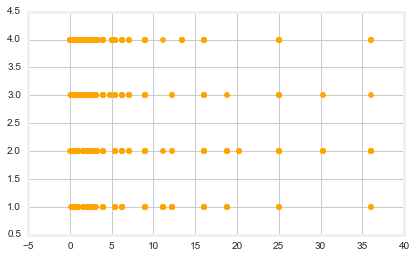

In [11]:
plt.scatter(household['SQBovercrowding'], household['Target'], color='orange', alpha=0.6, linewidth=1)

As we can see fromt the above plots, there is no clear boundary among these data points. We can check other variables, it's similar. Clustering might not be a good candidate classifier. 

check family members educational level and make a new varaible "edu_level" for instlevel1(no level of education) to instlevel9 ( postgraduate education), the higher the better

In [12]:
inst_levels = []
for c in household.columns:
    if c.startswith('instl'):
        inst_levels.append(c)
household[inst_levels].head()        

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
ID_279628684,0,0,0,1,0,0,0,0,0
ID_f29eb3ddd,0,0,0,0,0,0,0,1,0
ID_68de51c94,0,0,0,0,1,0,0,0,0
ID_d671db89c,0,0,0,1,0,0,0,0,0
ID_d56d6f5f5,0,0,0,0,1,0,0,0,0


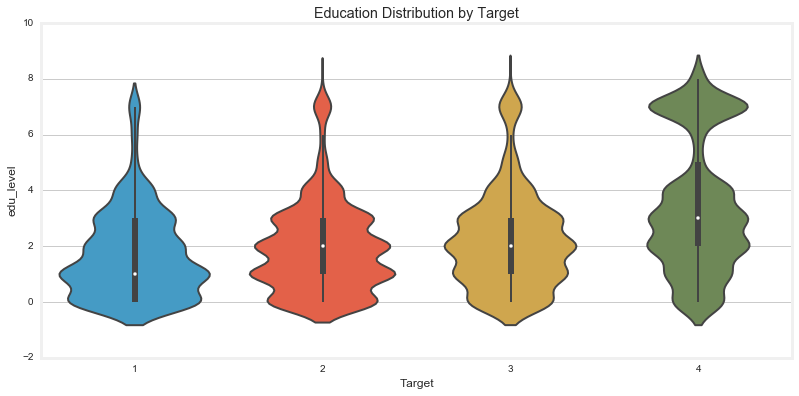

In [13]:
household['edu_level'] = np.argmax(np.array(household[inst_levels]), axis = 1)
household.drop(inst_levels, axis=1, inplace=True)

plt.figure(figsize = (12, 6))
sns.violinplot(x = 'Target', y = 'edu_level', data = household);
plt.title('Education Distribution by Target');

Remove highly correlated variables. The implementation refers to <b>Feature Selection</b> in https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

In [14]:
def drop_highly_corr(raw_df):
    corr_matrix = raw_df.corr()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
    raw_df.drop(to_drop, axis=1, inplace=True)
    print to_drop

drop_highly_corr(household) 

['coopele', 'SQBage', 'edu_level']


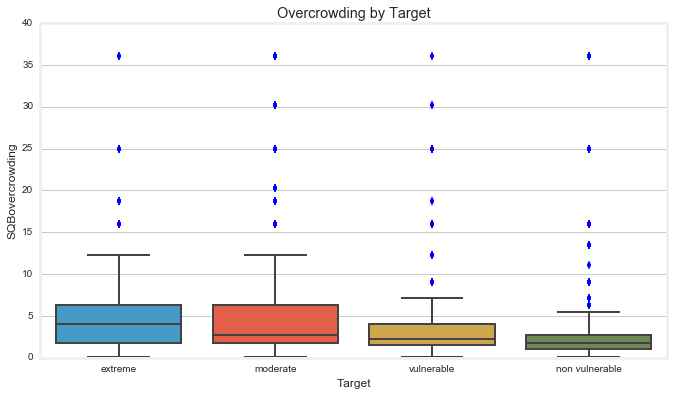

In [15]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'SQBovercrowding', data = household);
plt.xticks([0, 1, 2, 3], poverty_levels)
plt.title('Overcrowding by Target');

#### Normalize all non-binary variables
We know kNN model depends on a distance metric, feature scaling (limit the range of each column to between 0 and 1) is an absolute necessity. When comparing different models, it's always safest to scale the features. 

In [17]:
# Normalize all non-binary variables
hh_normalize(household)
household.head()

,hacdor,hacapo,v14a,refrig,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,...,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,Target,size_per_person,rent_per_person,phones_per_person,tablets_per_person,rooms_per_person
ID_279628684,0,0,1,1,0,0.125,0.125,0.000000,0.000000,0.000,...,0.000000,0.026696,0.000000,0.073046,4,1,0.190,0.333333,0.000000,0.320755
ID_f29eb3ddd,0,0,1,1,0,0.125,0.125,0.000000,0.000000,0.000,...,0.000000,0.026696,1.000000,0.105186,4,1,0.135,0.333333,0.333333,0.433962
ID_68de51c94,0,0,1,1,0,0.000,0.000,0.000000,0.166667,0.125,...,0.000000,0.005840,1.000000,0.088386,4,1,0.000,0.000000,0.000000,0.886792
ID_d671db89c,0,0,1,1,0,0.250,0.250,0.166667,0.166667,0.250,...,0.049383,0.048325,0.015625,0.088386,4,1,0.045,0.250000,0.083333,0.122642
ID_d56d6f5f5,0,0,1,1,0,0.250,0.250,0.166667,0.166667,0.250,...,0.049383,0.048325,0.015625,0.088386,4,1,0.045,0.250000,0.083333,0.122642


### Build and Compare models
cluster, kNN, Decision tree, Neural, Naive Bayes, and Gradient Boosting models will be explored first on all featured, then build models on features selected by PCA.

In [18]:
y = household['Target']
X = household.drop(['Target', 'idhogar'], axis=1, inplace=False)

#### Build models on all features

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

my_scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

<b>K-Means clustering </b>

In [23]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, init='random')
print cross_val_score(km, X, y, cv =5, scoring = my_scorer)


[ 0.07270007  0.08017864  0.07585779  0.11346348  0.12441226]


From the scores we can see that k-means clustering fit this problem not well, this conform to the scatter plots above.

<b>Other classifiers</b>

In [68]:
def k5_fold_fit(X_df, y, score_df):
    cv_ = 5
    
    knn = KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='ball_tree')
    score_df['kNN'] = cross_val_score(knn, X, y, cv = cv_, scoring = my_scorer)

    treeclf = DecisionTreeClassifier(max_depth=6, random_state=1)
    score_df['Decision Tree'] = cross_val_score(treeclf, X, y, cv = cv_, scoring = my_scorer)
    
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 2), random_state=1)
    score_df['Neural'] = cross_val_score(mlp, X, y, cv = cv_, scoring = my_scorer)
    
    # naive bayes
    nb = GaussianNB()
    score_df['Naive Bayes'] = cross_val_score(nb, X, y, cv = cv_, scoring = my_scorer)
    
    # Gradient Boosting
    gbc = GradientBoostingClassifier(n_estimators=100, random_state=10)
    score_df['Gradient Boosting'] = cross_val_score(gbc, X, y, cv = cv_, scoring = my_scorer)

#### Fit models

In [87]:
score_all = pd.DataFrame(columns=['kNN','Decision Tree','Neural','Naive Bayes','Gradient Boosting'])
k5_fold_fit(X, y, score_all)
print score_all.head()
score_all[score_all.columns[0:]].apply(np.mean, axis=0)

        kNN  Decision Tree    Neural  Naive Bayes  Gradient Boosting
0  0.236270       0.294074  0.402347     0.188551           0.332090
1  0.252074       0.329148  0.340572     0.130934           0.308287
2  0.222785       0.340140  0.269994     0.136759           0.230314
3  0.226434       0.196313  0.146965     0.059070           0.177778
4  0.303032       0.243116  0.215838     0.123317           0.308050


kNN                  0.248119
Decision Tree        0.280558
Neural               0.275143
Naive Bayes          0.127726
Gradient Boosting    0.271304
dtype: float64

We can see Neural network gives the highest score, 0.40, Navie Bayes gives the lowest score 0.05 and also the average score is only 0.13. Decision Tree is the winner averagely. Decision tree will be used to predict the test data.

### Use Decision Tree to predict test data

In [24]:
treeClf = DecisionTreeClassifier(max_depth=6, random_state=1)
tree_model = treeClf.fit(X, y)
tree_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

Show the most important (top 10) variables

In [31]:
var_importances = pd.DataFrame({'var': X.columns, 'importance': treeClf.feature_importances_})
var_importances.sort_values('importance', ascending=False).head(10)

,importance,var
111,0.257532,SQBmeaned
108,0.141578,SQBhogar_nin
114,0.126582,phones_per_person
110,0.066585,SQBdependency
115,0.038313,tablets_per_person
85,0.033712,hogar_adul
109,0.033578,SQBovercrowding
23,0.028735,pisomoscer
11,0.026677,r4t2
46,0.019775,energcocinar2


Perform the same process to prepare test data

In [102]:
raw_test = hh_load_data('test.csv')
submission = raw_test[['Id', 'idhogar']]
hh_fill_na(raw_test)
raw_test.head()

There are NA in variables: 
Index([u'v2a1', u'v18q1', u'rez_esc', u'meaneduc', u'SQBmeaned'], dtype='object')


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,0,0,5,0,1,1,0,0,1,...,4,0,16,9,0,1,2.25,0.25,272.250000,16
1,ID_1c78846d2,0,0,5,0,1,1,0,0,1,...,41,256,1681,9,0,1,2.25,0.25,272.250000,1681
2,ID_e5442cf6a,0,0,5,0,1,1,0,0,1,...,41,289,1681,9,0,1,2.25,0.25,272.250000,1681
3,ID_a8db26a79,0,0,14,0,1,1,1,1,0,...,59,256,3481,1,256,0,1.00,0.00,256.000000,3481
4,ID_a62966799,175000,0,4,0,1,1,1,1,0,...,18,121,324,1,0,1,0.25,64.00,83.859336,324


In [103]:
raw_test.set_index('Id', inplace=True)
raw_test.index.name = None
raw_test.drop(optout_vars, axis=1, inplace=True)
raw_test.drop([u'v18q', u'tamhog', u'area2', 'female'], axis=1, inplace=True)    
create_per_person_vars(raw_test)
raw_test.drop(inst_levels, axis=1, inplace=True)
raw_test.drop([u'coopele', u'SQBage'], axis=1, inplace=True)

As we need to give every household the same label, we just predict the records of household head. For all no household head, set target '3' because the bar chart of 'Distribution of Poverty Levels without Head' shows almost all are 3, only one is 4, and there is no 1 and 2.

In [104]:
test_df = raw_test[raw_test.parentesco1==1]
idhogar = test_df.idhogar.values
test_df.drop(['idhogar'], axis=1, inplace=True)
hh_normalize(test_df)
test_df.head(5)

,hacdor,hacapo,v14a,refrig,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,...,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,size_per_person,rent_per_person,phones_per_person,tablets_per_person,rooms_per_person
ID_e5442cf6a,0,0,1,1,0.166667,0.142857,0.285714,0,0.125,0.111111,...,0.000000,0.01,0.013194,0.003906,0.210069,1,0.000000,0.133333,0.000000,0.106529
ID_a8db26a79,0,0,1,1,0.000000,0.142857,0.142857,0,0.000,0.000000,...,0.580499,0.00,0.005797,0.000000,0.197531,1,0.000000,0.400000,0.333333,0.932990
ID_a62966799,0,0,1,1,0.000000,0.000000,0.000000,0,0.125,0.111111,...,0.000000,0.01,0.001359,1.000000,0.064706,1,0.184036,0.200000,0.333333,0.262887
ID_3c5f4bd51,0,0,1,1,0.000000,0.000000,0.000000,0,0.250,0.222222,...,0.000000,0.00,0.005797,0.000000,0.140625,1,0.210327,0.100000,0.166667,0.095361
ID_472fa82da,0,0,1,1,0.000000,0.000000,0.000000,0,0.250,0.222222,...,0.000000,0.00,0.001359,0.000000,0.151235,1,0.157745,0.200000,0.166667,0.195876


In [105]:
result = tree_model.predict(test_df)
p_dict = {}
for i in range(len(idhogar)):
    p_dict[idhogar[i]] = result[i]
    
def map_target(v):
    if p_dict.has_key(v):
        return p_dict[v]
    else:
        return 3

submission['Target'] = submission[["idhogar"]].applymap(map_target)
submission.drop(['idhogar'], axis=1, inplace=True)
submission.to_csv('bevan_submission.csv', index=False)

### Conclusion


Kaggle score and leaderboard screen snapshot as below. There is a significant gap between my result and the board leaders. There are much spaces to improve for Data EDA, features selection and model optimization.

<img src=score.JPG width=1000>

I submitted second time with this notebook after the competition completed and got a higher score as below
<img src=second.JPG width=1000>